## Next Steps (Milestone 2+)

The next steps will include the data preparation. Our goal here will be to sort the Data of the days of the month in time boxes for example morning, noon, afternoon, evening etc. With this we can accumulate the highest average of use-time through the day as well as highest and lowest peaks.


Remaining data points: 165


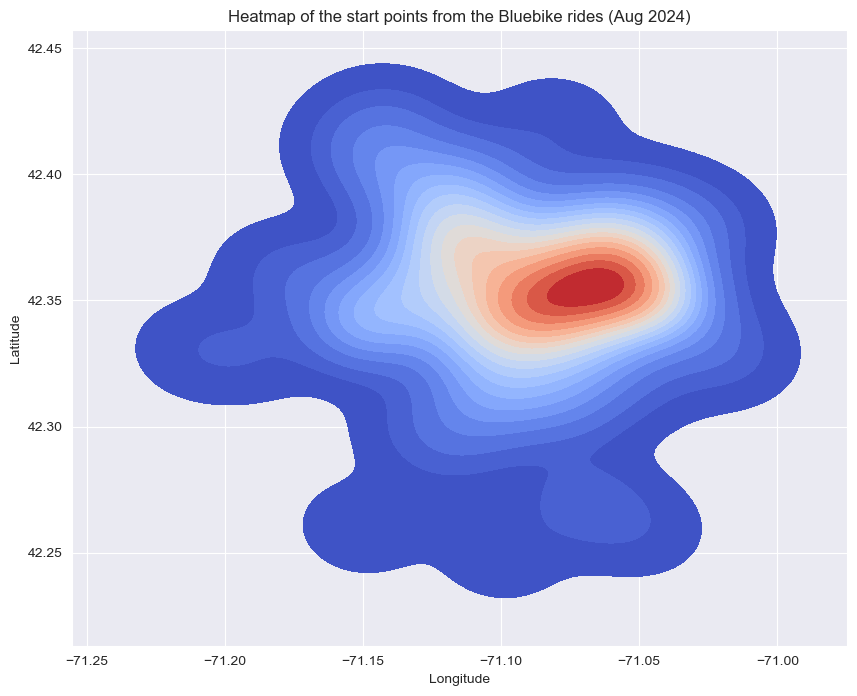

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV (adjust separator, skip malformed rows)
df_trips = pd.read_csv('202408-bluebikes-tripdata.csv', sep=';', on_bad_lines='skip')

# Convert start time to datetime
df_trips['started_at'] = pd.to_datetime(df_trips['started_at'], format='%d.%m.%Y %H:%M', errors='coerce')

# Drop rows with invalid date
df_trips = df_trips.dropna(subset=['started_at'])

# Convert coordinate columns to numeric
for col in ['start_lat', 'start_lng', 'end_lat', 'end_lng']:
    df_trips[col] = pd.to_numeric(df_trips[col], errors='coerce')

# Drop rows with missing coordinates
df_trips = df_trips.dropna(subset=['start_lat', 'start_lng'])

# Filter unrealistic coordinates (rough bounds for Boston)
df_trips = df_trips[
    (df_trips['start_lat'] > 42.0) & (df_trips['start_lat'] < 43.0) &
    (df_trips['start_lng'] > -72.0) & (df_trips['start_lng'] < -70.0)
]

# Output for validation
print("Remaining data points:", len(df_trips))

# Plot heatmap of start locations
plt.figure(figsize=(10, 8))
sns.kdeplot(
    x=df_trips['start_lng'],
    y=df_trips['start_lat'],
    cmap="coolwarm",
    fill=True,
    thresh=0.01,
    levels=20
)
plt.title('Heatmap of the start points from the Bluebike rides (Aug 2024)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


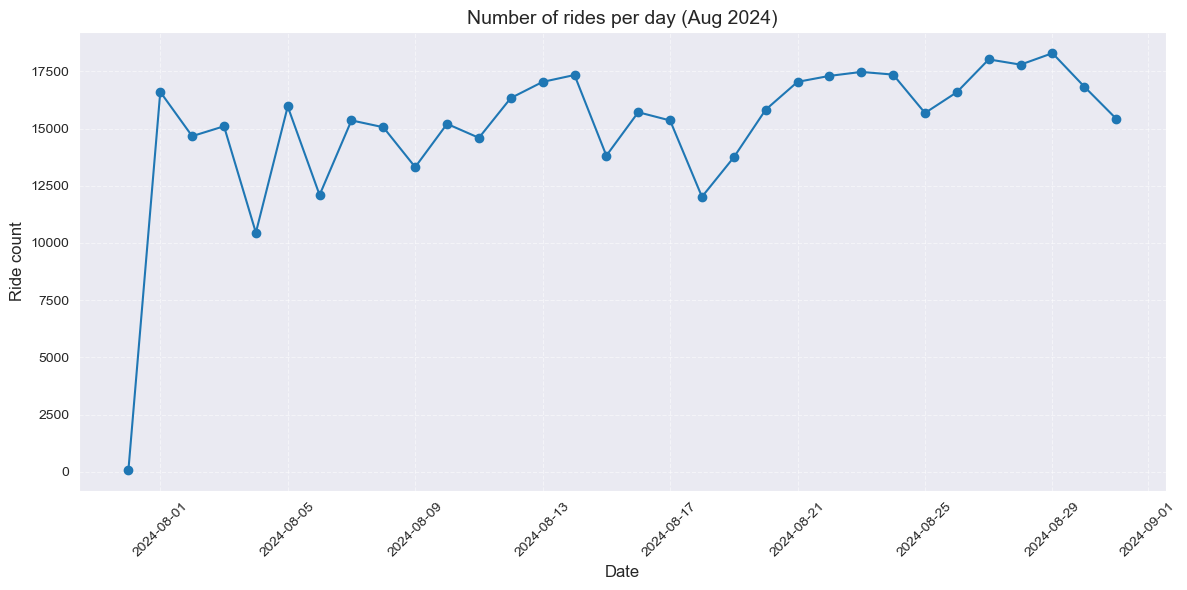

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Read CSV file (semicolon-separated)
df_trips = pd.read_csv('202408-bluebikes-tripdata.csv', sep=';')

# 2) Convert 'started_at' to datetime (day.month.year hour:minute)
df_trips['started_at'] = pd.to_datetime(
    df_trips['started_at'],
    format='%d.%m.%Y %H:%M',
    dayfirst=True,
    errors='coerce'
)

# Remove invalid or missing timestamps
df_trips = df_trips.dropna(subset=['started_at'])

# Extract only the date
df_trips['date'] = df_trips['started_at'].dt.date

# Calculate number of rides per day
rides_per_day = df_trips.groupby('date').size()

# Create plot
plt.figure(figsize=(12, 6))
rides_per_day.plot(
    marker='o',
    linestyle='-',
    linewidth=1.5
)
plt.title("Number of rides per day (Aug 2024)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Ride count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



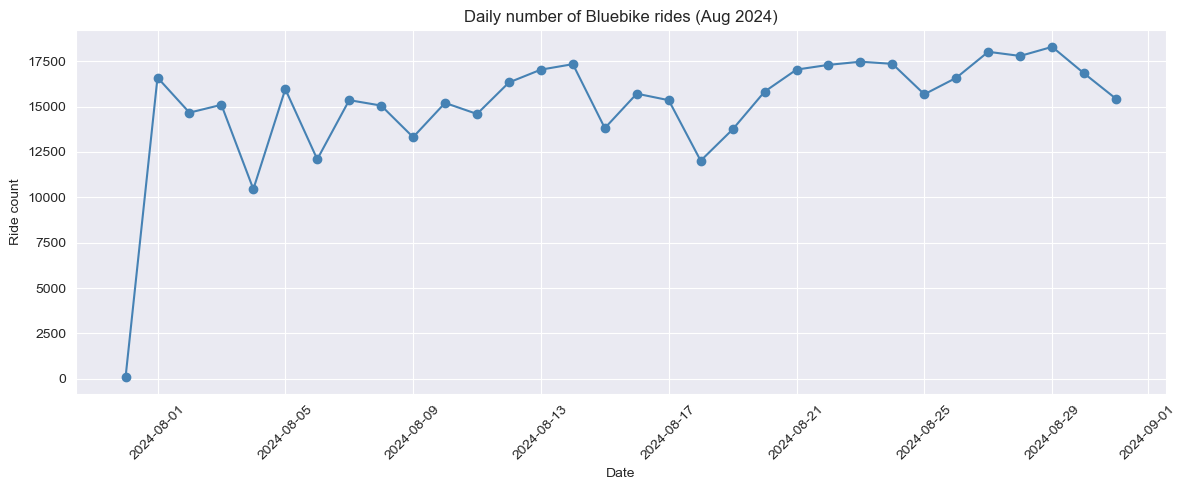

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Read CSV file
df_trips = pd.read_csv('202408-bluebikes-tripdata.csv', sep=';', on_bad_lines='skip')

# Parse date
df_trips['started_at'] = pd.to_datetime(df_trips['started_at'], format='%d.%m.%Y %H:%M', errors='coerce')
df_trips = df_trips.dropna(subset=['started_at'])

# Set index
df_trips.set_index('started_at', inplace=True)

# Calculate daily number of rides
daily_counts = df_trips.resample('D').size()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(daily_counts, marker='o', linestyle='-', color='steelblue')
plt.title('Daily number of Bluebike rides (Aug 2024)')
plt.xlabel('Date')
plt.ylabel('Ride count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


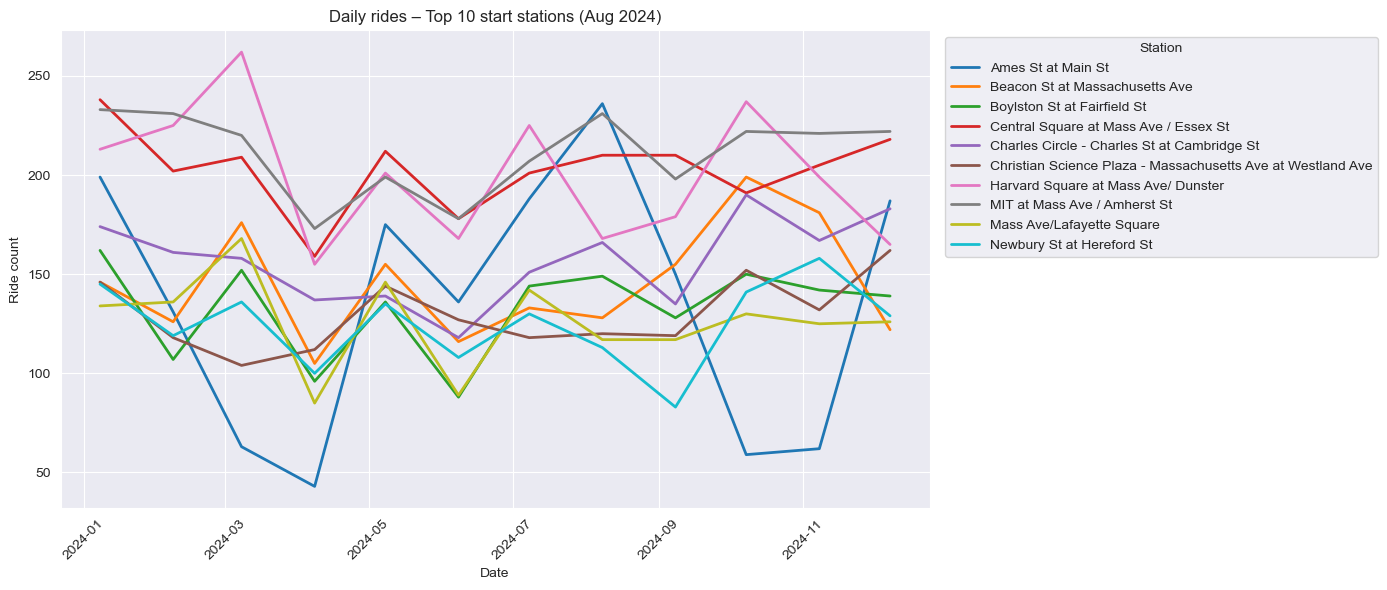

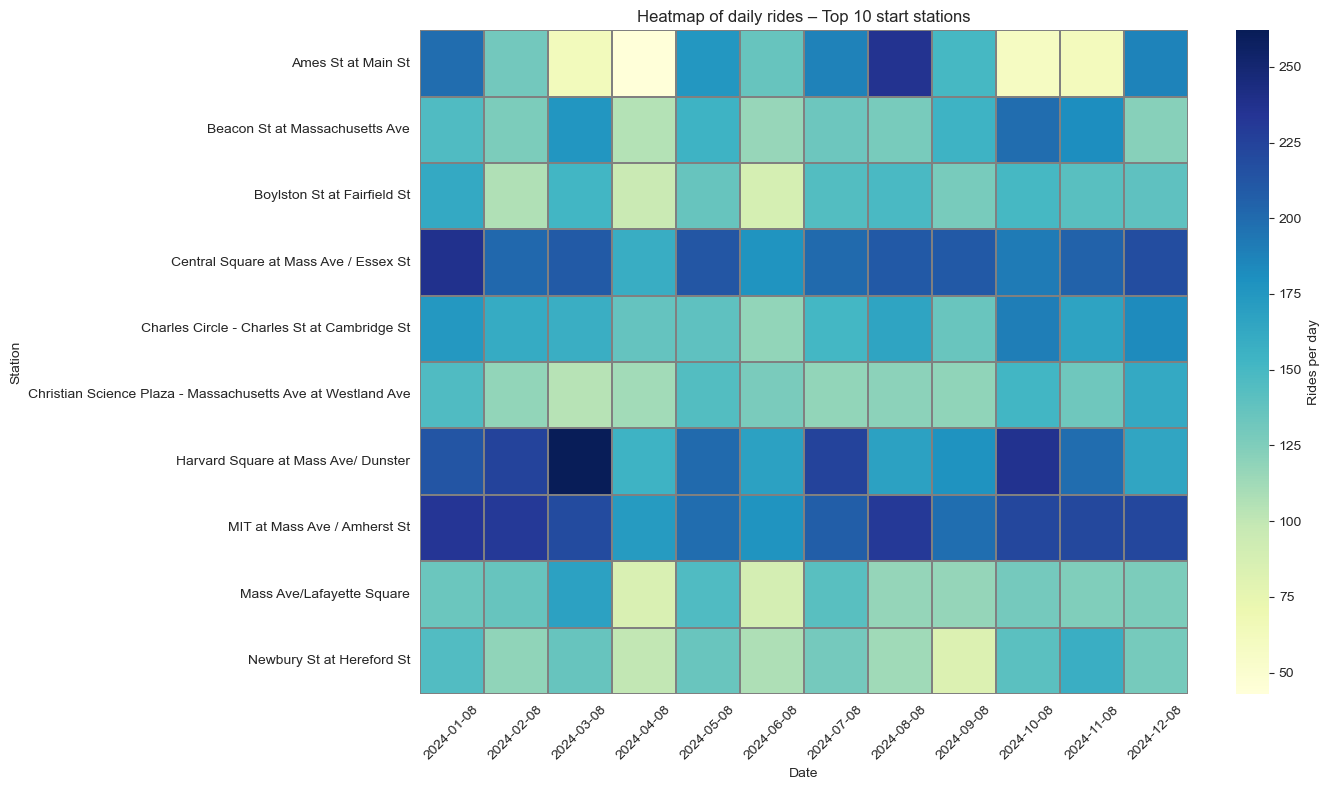

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('202408-bluebikes-tripdata.csv', sep=';')

# Auto-detect start time column
datetime_col = next(
    (col for col in df.columns if 'start' in col.lower() and ('at' in col.lower() or 'time' in col.lower())),
    None
)
if datetime_col is None:
    raise ValueError("No valid start time column found.")

# Convert to datetime
df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
df = df.dropna(subset=[datetime_col])

# Extract date only
df['date'] = df[datetime_col].dt.date

# Calculate total rides per start station
station_totals = df['start_station_name'].value_counts()

# Keep only the top 10 stations
top_stations = station_totals.head(10).index
df_top = df[df['start_station_name'].isin(top_stations)]

# Group by station and date
usage = (
    df_top
    .groupby(['start_station_name', 'date'])
    .size()
    .reset_index(name='trip_count')
)

# Pivot table (date × top stations)
usage_pivot = (
    usage
    .pivot(index='date', columns='start_station_name', values='trip_count')
    .fillna(0)
)

# Line chart of Top 10 stations due to clearer visualization
plt.figure(figsize=(14, 6))
for station in usage_pivot.columns:
    plt.plot(usage_pivot.index, usage_pivot[station], lw=2, label=station)

plt.xlabel('Date')
plt.ylabel('Ride count')
plt.title('Daily rides – Top 10 start stations (Aug 2024)')
plt.legend(title='Station', loc='upper left', bbox_to_anchor=(1.01, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Heatmap of all stations
plt.figure(figsize=(14, 8))
sns.heatmap(
    usage_pivot.T,
    cmap='YlGnBu',
    cbar_kws={'label': 'Rides per day'},
    linewidths=0.3,
    linecolor='gray'
)
plt.xlabel('Date')
plt.ylabel('Station')
plt.title('Heatmap of daily rides – Top 10 start stations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv("202408-bluebikes-tripdata.csv", sep=";")

# Parse datetime columns
df['started_at'] = pd.to_datetime(df['started_at'], format="%d.%m.%Y %H:%M", errors='coerce')
df['ended_at'] = pd.to_datetime(df['ended_at'], format="%d.%m.%Y %H:%M", errors='coerce')

# Calculate trip duration in minutes
df['duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

# Remove rows with missing or invalid data
df = df.dropna(subset=['started_at', 'ended_at', 'duration_min', 'start_station_name', 'end_station_name'])
df = df[df['duration_min'] > 0]
df = df[df['duration_min'] < 120]

# Extract temporal features
df['hour'] = df['started_at'].dt.hour
df['weekday'] = df['started_at'].dt.weekday
df['month'] = df['started_at'].dt.month

# Limit the number of stations to the top 20 most frequent start and end stations
top_start_stations = df['start_station_name'].value_counts().nlargest(20).index
top_end_stations = df['end_station_name'].value_counts().nlargest(20).index
df = df[df['start_station_name'].isin(top_start_stations) & df['end_station_name'].isin(top_end_stations)]

# Define features
features = ['start_station_name', 'end_station_name', 'hour', 'weekday', 'month']

# Encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(df[features])
X = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(features))
y = df['duration_min']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model with limited depth and fewer trees
model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f} minutes")


RMSE: 13.66 minutes


C:\Users\hanac\AppData\Local\Temp\ipykernel_9324\2494386500.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['week'] = pd.to_datetime(df_top10['date']).dt.to_period('W').apply(lambda r: r.start_time.strftime('%Y-%m-%d'))


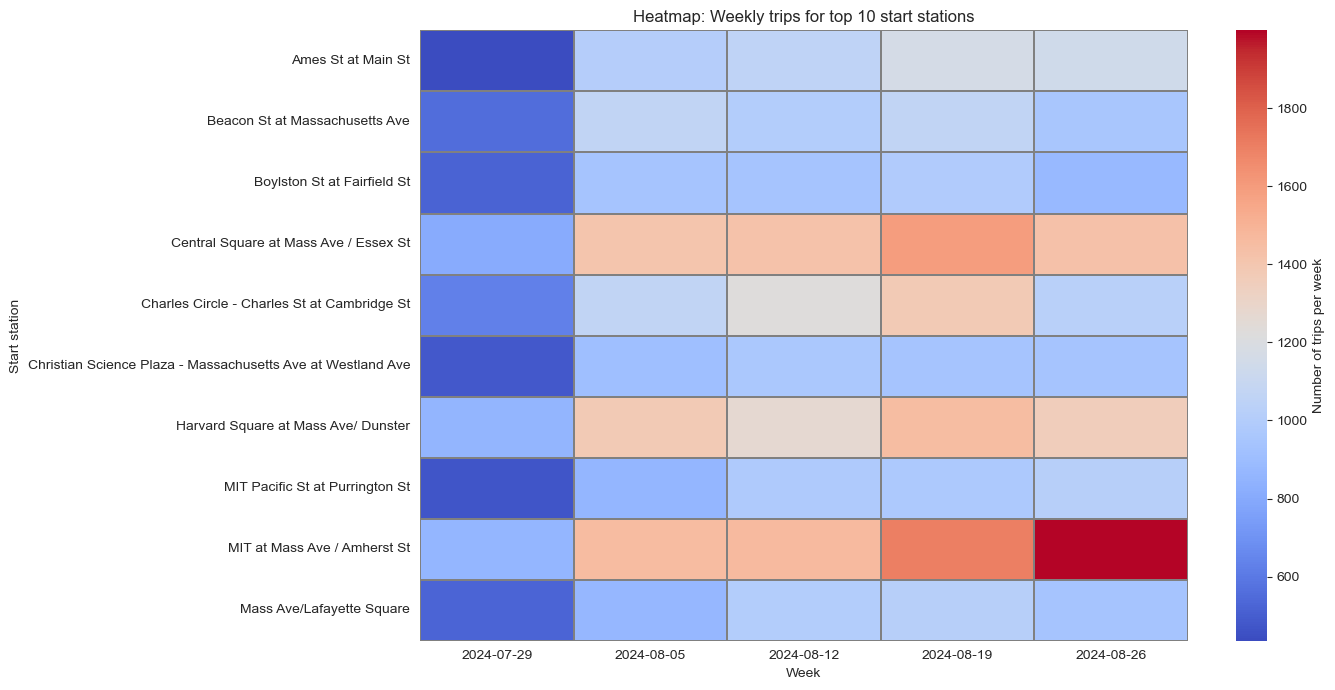

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV and parse date
df = pd.read_csv('202408-bluebikes-tripdata.csv', sep=';')
df['started_at'] = pd.to_datetime(df['started_at'], dayfirst=True, errors='coerce')
df['date'] = df['started_at'].dt.date
df_clean = df.dropna(subset=['start_station_name', 'date'])

# Top 10 stations by total number of trips
top10 = (
    df_clean.groupby('start_station_name')
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
)

df_top10 = df_clean[df_clean['start_station_name'].isin(top10)]

# Weekly aggregation (calendar weeks)
df_top10['week'] = pd.to_datetime(df_top10['date']).dt.to_period('W').apply(lambda r: r.start_time.strftime('%Y-%m-%d'))

usage_weekly = (
    df_top10.groupby(['start_station_name', 'week'])
    .size()
    .reset_index(name='trip_count')
)

usage_pivot_weekly = usage_weekly.pivot(index='week', columns='start_station_name', values='trip_count').fillna(0)

# Heatmap with weeks and top 10 stations
plt.figure(figsize=(14, 7))
sns.heatmap(
    usage_pivot_weekly.T,
    cmap='coolwarm',
    cbar_kws={'label': 'Number of trips per week'},
    linewidths=0.3,
    linecolor='gray'
)
plt.title('Heatmap: Weekly trips for top 10 start stations')
plt.xlabel('Week')
plt.ylabel('Start station')
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd

# Load CSV file with automatic delimiter detection and skip bad lines
df = pd.read_csv(
    '202408-bluebikes-tripdata.csv',
    engine='python',
    sep=None,
    on_bad_lines='skip'
)

# Print the loaded column names
print("Loaded columns:", df.columns.tolist())

# Show the first 5 rows of the DataFrame
df.head()


Loaded columns: ['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,9555B91492D25570,classic_bike,01.08.2024 07:10,01.08.2024 07:26,Main St at Baldwin St,D32036,Purchase St at Pearl St,A32026,42.380.857,-71.070.629,42.354.659,-71.053.181,member
1,82D93E8BDD45E43F,electric_bike,12.08.2024 15:43,12.08.2024 15:46,75 Binney St,M32064,Cambridge Crossing at North First Street,M32077,4.236.550.728.505.650,-710.801.375.997.653,42.371.141,-71.076.198,member
2,C99E6E4F4C76DFF9,classic_bike,28.08.2024 21:06,28.08.2024 21:10,Copley Square - Dartmouth St at Boylston St,D32005,Prudential Center - 101 Huntington Ave,C32007,4.234.992.828.230.050,-7.107.739.206.866.420,4.234.652.003.998.410,-7.108.065.776.545.110,member
3,AB67BC6000A4D4CE,classic_bike,11.08.2024 13:14,11.08.2024 13:21,Ink Block - Harrison Ave at Herald St,C32025,Massachusetts Ave at Columbus Ave,C32004,42.345.901,-71.063.187,42.340.835,-710.816.197,member
4,C0B1FA5CE04B942F,electric_bike,12.08.2024 10:43,12.08.2024 11:59,Copley Square - Dartmouth St at Boylston St,D32005,Prudential Center - 101 Huntington Ave,C32007,4.234.992.828.230.050,-7.107.739.206.866.420,4.234.652.003.998.410,-7.108.065.776.545.110,member


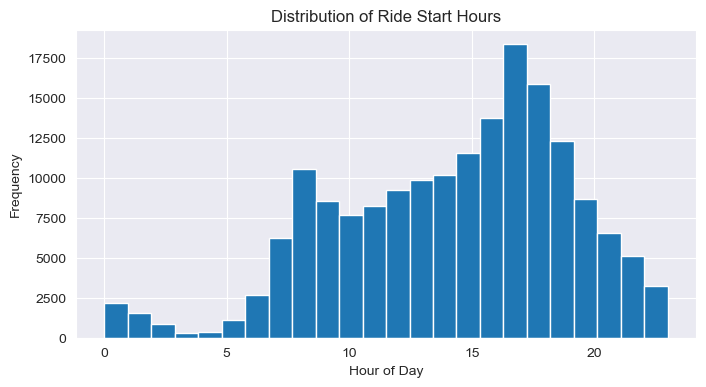

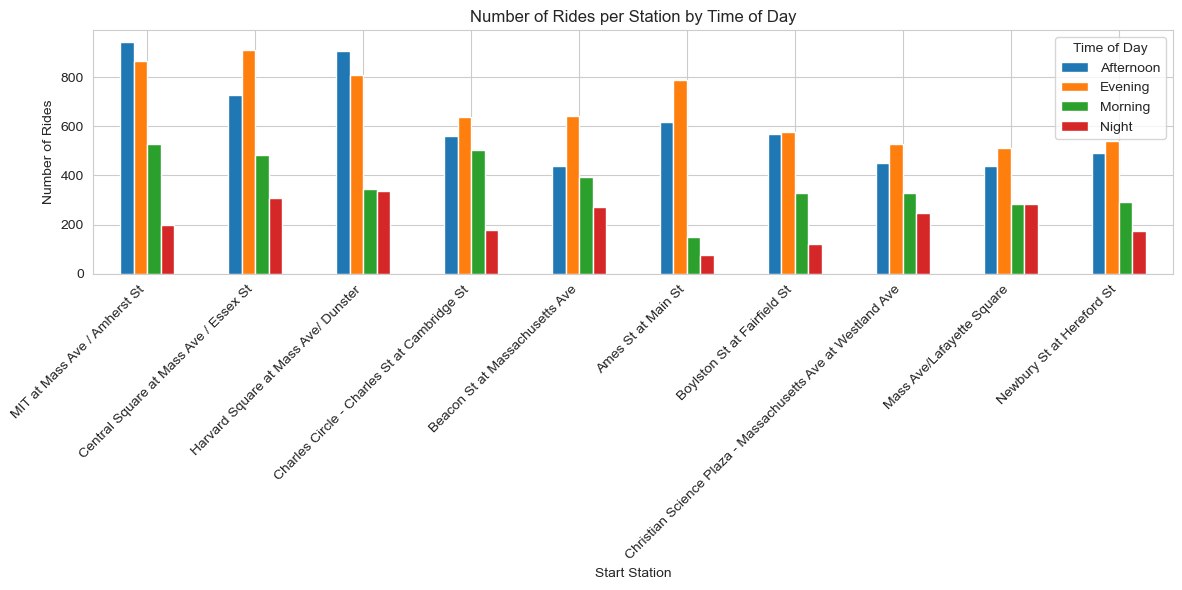

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv(
    '202408-bluebikes-tripdata.csv',
    engine='python',
    sep=None,
    on_bad_lines='skip'
)

# Convert start time column to datetime
df['started_at'] = pd.to_datetime(df['started_at'], errors='coerce')

# Drop rows with invalid datetime
df = df.dropna(subset=['started_at'])

# Extract hour of the day from start time
df['hour'] = df['started_at'].dt.hour

# Plot distribution of ride start times by hour
df['hour'].plot.hist(bins=24, figsize=(8, 4), title='Distribution of Ride Start Hours')
plt.xlabel("Hour of Day")
plt.show()

# Categorize time of day
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_of_day_category'] = df['hour'].apply(get_time_of_day)

# Group by station and time of day
rides_by_station_time = (
    df.groupby(['start_station_name', 'time_of_day_category'])
      .size()
      .reset_index(name='ride_count')
)

# Pivot to wide format (station x time of day)
pivot_df = rides_by_station_time.pivot(
    index='start_station_name',
    columns='time_of_day_category',
    values='ride_count'
).fillna(0)

# Keep only top 10 stations by total ride count
top10 = pivot_df.sum(axis=1).nlargest(10).index
pivot_top10 = pivot_df.loc[top10]

# Plot grouped bar chart
sns.set_style("whitegrid")
pivot_top10.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Rides per Station by Time of Day')
plt.xlabel('Start Station')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Time of Day')
plt.tight_layout()
plt.show()
